In [23]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
from torchsummary import summary

from resnet import ResNet18  # Import baseline ResNet-18 model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preparation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add jitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Initialize Baseline Model
print('==> Building ResNet-18 Baseline Model..')
net = ResNet18().to(device)
summary(net, (3, 32, 32))  # Display parameter count

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Building ResNet-18 Baseline Model..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728

In [24]:

# Training & Evaluation Functions
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    print(f'Train Epoch {epoch}: Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}%')
    return train_loss / (batch_idx+1), 100.*correct/total

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    print(f'Test Epoch {epoch}: Loss: {test_loss/(batch_idx+1):.3f} | Acc: {acc:.3f}%')
    return test_loss / (batch_idx+1), acc


In [25]:

# Training Loop with Logging
num_epochs = 150
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)


Train Epoch 0: Loss: 2.037 | Acc: 27.482%
Test Epoch 0: Loss: 1.583 | Acc: 41.590%
Train Epoch 1: Loss: 1.564 | Acc: 42.342%
Test Epoch 1: Loss: 1.329 | Acc: 51.720%
Train Epoch 2: Loss: 1.284 | Acc: 53.574%
Test Epoch 2: Loss: 1.168 | Acc: 57.840%
Train Epoch 3: Loss: 1.110 | Acc: 60.532%
Test Epoch 3: Loss: 0.911 | Acc: 67.730%
Train Epoch 4: Loss: 0.968 | Acc: 65.858%
Test Epoch 4: Loss: 0.902 | Acc: 69.120%
Train Epoch 5: Loss: 0.898 | Acc: 68.488%
Test Epoch 5: Loss: 0.884 | Acc: 69.990%
Train Epoch 6: Loss: 0.844 | Acc: 70.540%
Test Epoch 6: Loss: 0.806 | Acc: 71.700%
Train Epoch 7: Loss: 0.810 | Acc: 71.846%
Test Epoch 7: Loss: 0.774 | Acc: 74.270%
Train Epoch 8: Loss: 0.785 | Acc: 73.106%
Test Epoch 8: Loss: 0.857 | Acc: 72.350%
Train Epoch 9: Loss: 0.771 | Acc: 73.392%
Test Epoch 9: Loss: 0.804 | Acc: 73.200%
Train Epoch 10: Loss: 0.750 | Acc: 74.250%
Test Epoch 10: Loss: 0.731 | Acc: 74.800%
Train Epoch 11: Loss: 0.735 | Acc: 74.594%
Test Epoch 11: Loss: 0.957 | Acc: 69.880%


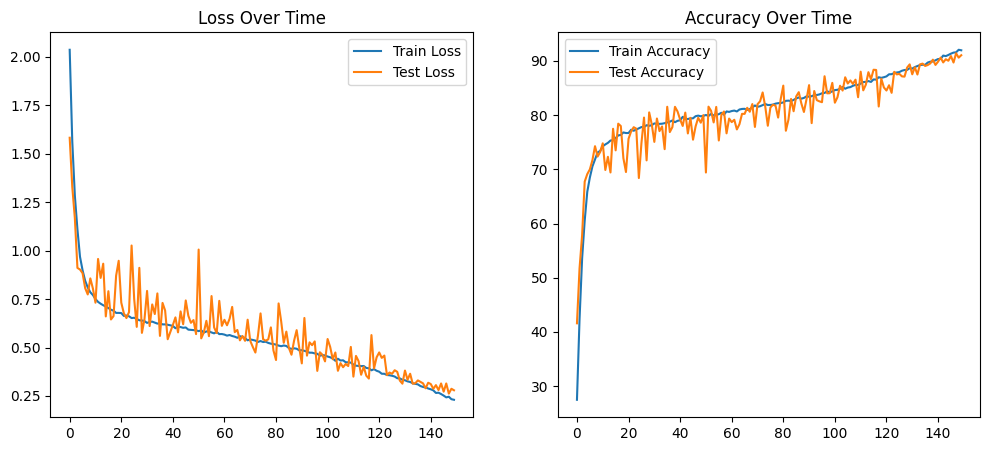

In [26]:

# Plot Training Progress
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()


In [27]:
from collections import Counter
predicted_classes = []
for inputs, _ in testloader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = outputs.max(1)
    predicted_classes.extend(predicted.cpu().numpy())

print(Counter(predicted_classes))


Counter({np.int64(5): 1091, np.int64(9): 1063, np.int64(8): 1060, np.int64(6): 1023, np.int64(7): 1013, np.int64(2): 986, np.int64(4): 977, np.int64(0): 958, np.int64(1): 926, np.int64(3): 903})


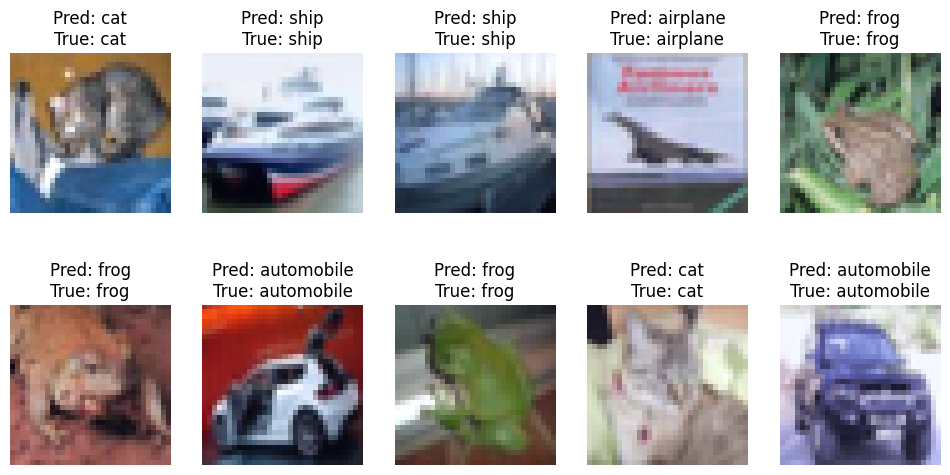

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict
net.eval()
outputs = net(images.to(device))
_, predicted = outputs.max(1)

# Display
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to image
    ax.imshow((img * 0.2 + 0.5).clip(0, 1))  # Unnormalize
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')

plt.show()


In [29]:
model_path = "cifar10_resnet18.pth"

# If using DataParallel, remove the module wrapper before saving
if isinstance(net, torch.nn.DataParallel):
    torch.save(net.module.state_dict(), model_path)  # Save model without "module" prefix
else:
    torch.save(net.state_dict(), model_path)  # Save normally

print(f"Model saved to {model_path}")


Model saved to cifar10_resnet18.pth


In [30]:
# Load the saved model
net = ResNet18().to(device)
net.load_state_dict(torch.load(model_path))
net.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

# Run test evaluation
test_loss, test_acc = test(num_epochs)  # Running test on the loaded model


Model loaded successfully.
Test Epoch 150: Loss: 0.279 | Acc: 91.050%


In [32]:
import pandas as pd
import numpy as np

# Prepare for inference
predictions = []

net.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    for batch_idx, (inputs, _) in enumerate(testloader):  # Ignore labels
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)  # Get predicted class

        # Store predictions
        predictions.extend(predicted.cpu().numpy())

# Create a Kaggle submission CSV
submission_df = pd.DataFrame({"ID": np.arange(len(predictions)), "Label": predictions})
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")


Submission file saved as submission.csv
